<a href="https://colab.research.google.com/github/Natali82-03/1/blob/main/OpenLessons/ts-feature-extraction/notebooks/1-HAR-FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal processing for Human Activity Recognition (HAR)

Source: http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

In [29]:
import sys
sys.path.append(
    "/content/src"
)

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal

from src.detect_peaks import detect_peaks
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

In [30]:
# # 3) Добавить папку в sys.path
# import sys
# sys.path.append('/content/src')

# # 4) Импорт необходимых библиотек
# import pandas as pd
# import numpy as np
# import time
# from tqdm.autonotebook import tqdm
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.signal import welch
# from scipy.fftpack import fft
# from scipy import signal

# # 5) Импорт пользовательских модулей
# from detect_peaks import detect_peaks
# from utils import *
# # при необходимости:
# # from signal_processing import <функции>

# import warnings
# warnings.filterwarnings('ignore')


In [31]:
# Проверим, что модули доступны
print(detect_peaks)           # должно вывести объект функции
print(dir())                  # проверить, что нет ошибок импорта


<function detect_peaks at 0x7d05ad9e20c0>
['INPUT_FOLDER_TEST', 'INPUT_FOLDER_TRAIN', 'In', 'LABELFILE_TEST', 'LABELFILE_TRAIN', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'activities_description', 'activities_labels', 'confusion_matrix', 'detect_peaks', 'drive', 'exit', 'fft', 'find_peaks', 'get_autocorr_values', 'get_fft_values', 'get_ipython', 'get_psd_values', 'get_values', 'load_activity_labels', 'load_features', 'np', 'os', 'pd', 'plot_confusion', 'plt', 'quit', 'randomize', 'read_data', 'read_labels', 'read_signals', 'signal', 'sns', 'sys', 'time', 'tqdm', 'url', 'urllib', 'warnings', 'welch', 'zip_path', 'zip_ref

In [36]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

activities_labels = [
    'walking',
    'walking upstairs',
    'walking downstairs',
    'sitting',
    'standing',
    'laying'
]

In [37]:
import os
import zipfile
import urllib.request

# Создание структуры папок
!mkdir -p /content/data/raw

# Скачивание датасета
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
zip_path = "/content/data/raw/UCI_HAR_Dataset.zip"

print("Скачивание датасета...")
urllib.request.urlretrieve(url, zip_path)

# Распаковка архива
print("Распаковка архива...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data/raw/")

print("Датасет успешно загружен!")


Скачивание датасета...
Распаковка архива...
Датасет успешно загружен!


In [40]:
# Проверим структуру распакованного датасета
!ls -la /content/data/raw/
!ls -la /content/data/raw/UCI\ HAR\ Dataset/
!ls -la /content/data/raw/UCI\ HAR\ Dataset/train/
!ls -la /content/data/raw/UCI\ HAR\ Dataset/test/


total 59588
drwxr-xr-x 4 root root     4096 Oct 21 14:31  .
drwxr-xr-x 3 root root     4096 Oct 21 14:31  ..
drwxr-xr-x 3 root root     4096 Oct 21 14:31  __MACOSX
drwxr-xr-x 4 root root     4096 Oct 21 14:31 'UCI HAR Dataset'
-rw-r--r-- 1 root root 60999314 Oct 21 14:39  UCI_HAR_Dataset.zip
total 56
drwxr-xr-x 4 root root  4096 Oct 21 14:31 .
drwxr-xr-x 4 root root  4096 Oct 21 14:31 ..
-rw-r--r-- 1 root root    80 Oct 21 14:38 activity_labels.txt
-rw-r--r-- 1 root root  6148 Oct 21 14:38 .DS_Store
-rw-r--r-- 1 root root  2809 Oct 21 14:38 features_info.txt
-rw-r--r-- 1 root root 15785 Oct 21 14:38 features.txt
-rw-r--r-- 1 root root  6304 Oct 21 14:38 README.txt
drwxr-xr-x 3 root root  4096 Oct 21 14:31 test
drwxr-xr-x 3 root root  4096 Oct 21 14:31 train
total 64508
drwxr-xr-x 3 root root     4096 Oct 21 14:31  .
drwxr-xr-x 4 root root     4096 Oct 21 14:31  ..
drwxr-xr-x 2 root root     4096 Oct 21 14:31 'Inertial Signals'
-rw-r--r-- 1 root root    20152 Oct 21 14:38  subject_train

In [41]:
# Правильные пути для Colab
INPUT_FOLDER_TRAIN = '/content/data/raw/UCI HAR Dataset/train/Inertial Signals/'
INPUT_FOLDER_TEST = '/content/data/raw/UCI HAR Dataset/test/Inertial Signals/'

LABELFILE_TRAIN = '/content/data/raw/UCI HAR Dataset/train/y_train.txt'
LABELFILE_TEST = '/content/data/raw/UCI HAR Dataset/test/y_test.txt'


In [42]:
# Убедитесь, что utils.py загружен в /content/src/
import sys
sys.path.append('/content/src')
from utils import read_data

# Загружаем данные
train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

# Проверим размерности данных
print(f"Train signals shape: {train_signals.shape}")    # (7352, 128, 9)
print(f"Test signals shape: {test_signals.shape}")      # (2947, 128, 9)
print(f"Train labels length: {len(train_labels)}")      # 7352
print(f"Test labels length: {len(test_labels)}")        # 2947


Train signals shape: (7352, 128, 9)
Test signals shape: (2947, 128, 9)
Train labels length: 7352
Test labels length: 2947


In [43]:
train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [44]:
train_signals.shape

(7352, 128, 9)

In [45]:
test_signals.shape

(2947, 128, 9)

# 1. EDA

In [46]:
N = 128     # длина сигнала
f_s = 50    # частота Hz
t_n = 2.56  # длина нашего сигнала в секундах
T = t_n / N # период сигнала
sample_rate = 1 / f_s
denominator = 10

## Посмотрим на случайное наблюдение

In [47]:
signal_no = 15
signals = train_signals[signal_no, :, :]
signal = signals[:, 3]
label = train_labels[signal_no]
activity_name = activities_description[label]

In [48]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = np.array([sample_rate * kk for kk in range(0,len(y_values))])
    return x_values, y_values

In [49]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

xlabel = 'Time [sec]'
ylabel = 'Amplitude'
axtitles = ['Acceleration', 'Gyro', 'Total acceleration']

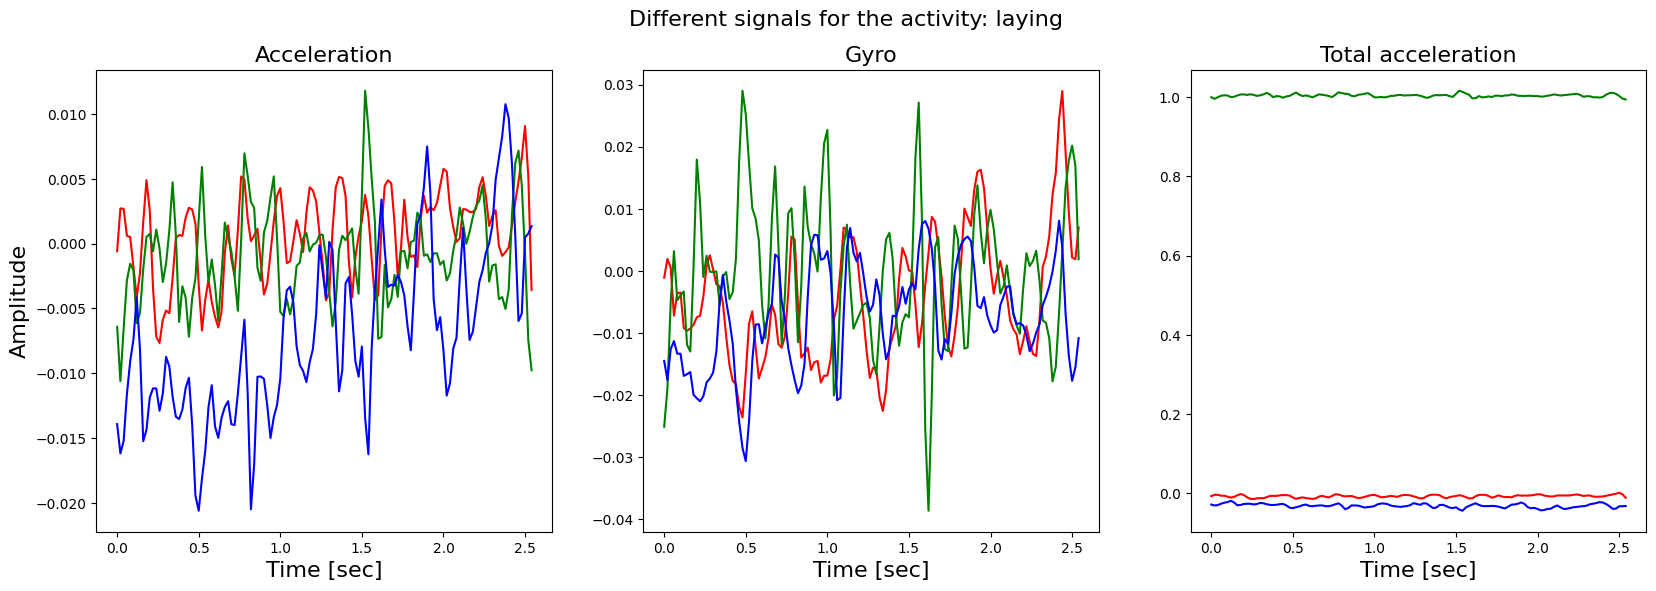

In [50]:
signal_no = 5
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]

f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for comp_no in range(0,9):
    col_no = comp_no // 3
    plot_no = comp_no % 3
    color = colors[plot_no]
    label = labels[plot_no]
    axtitle  = axtitles[col_no]
    ax = axarr[col_no]
    ax.set_title(axtitle, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    if col_no == 0:
        ax.set_ylabel(ylabel, fontsize=16)

    signal_component = signals[:, comp_no]
    x_values, y_values = get_values(signal_component, T, N, f_s)
    ax.plot(x_values, y_values, linestyle='-', color=color, label=label)

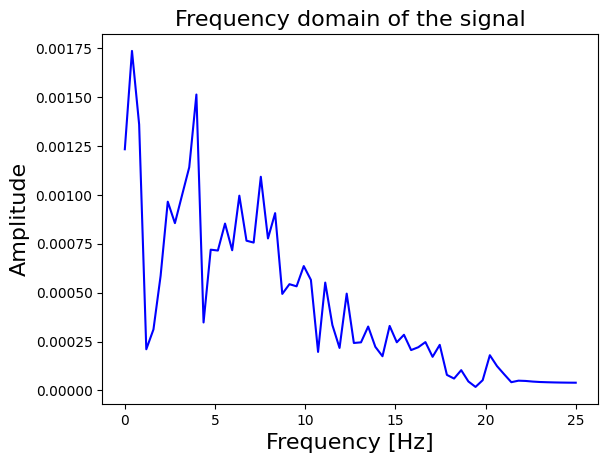

In [51]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

f_values, fft_values = get_fft_values(signals[:, 0], T, N, f_s)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

# 2. Feature Extraction

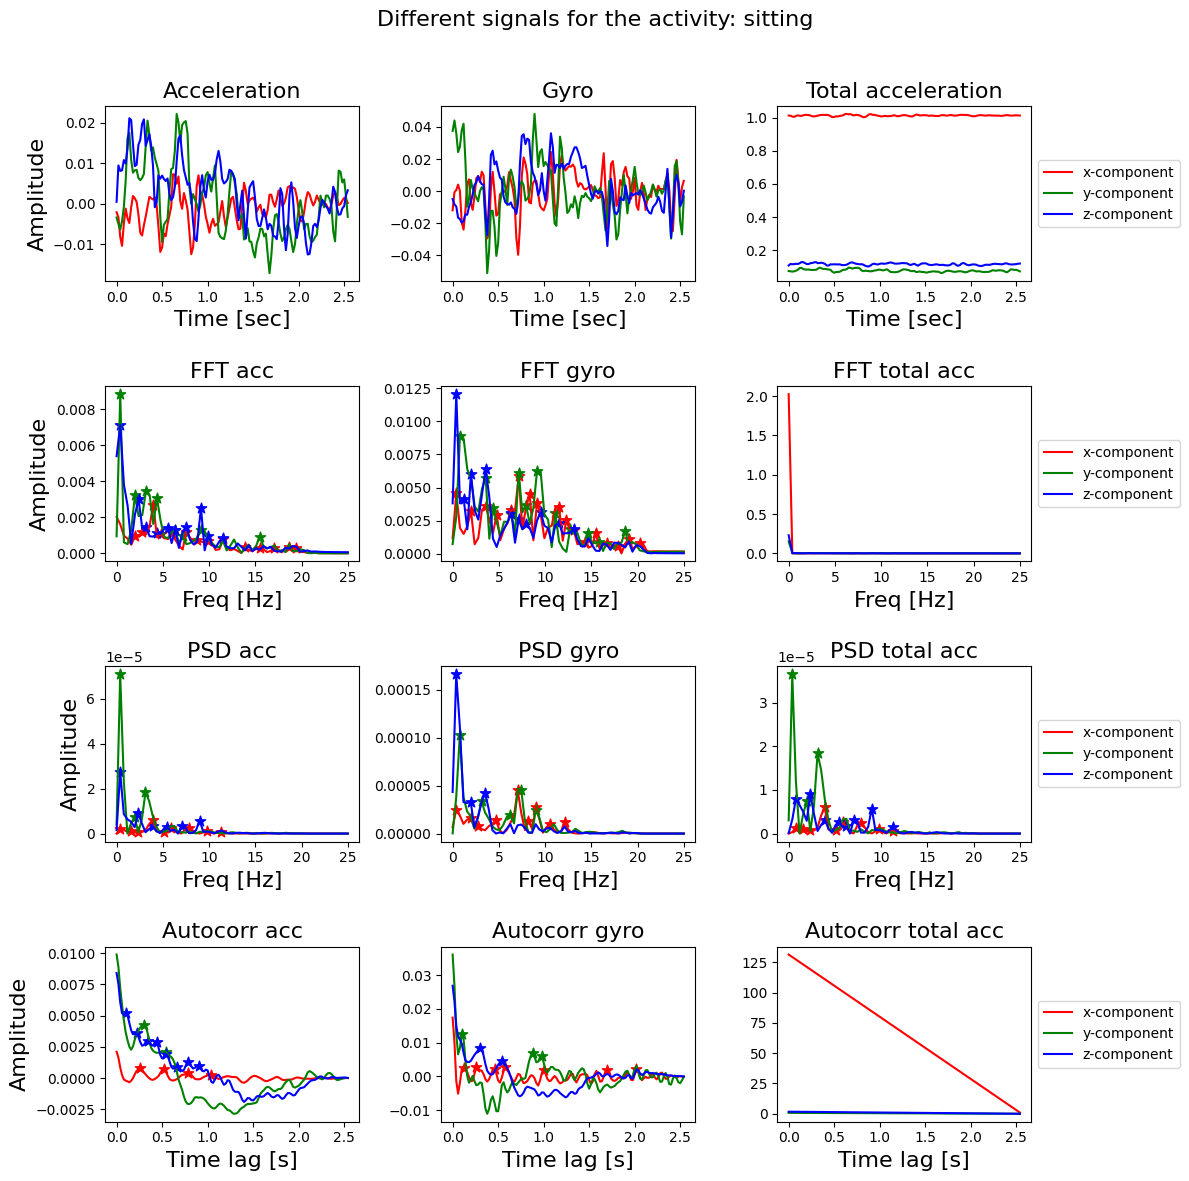

In [52]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = np.array([sample_rate * kk for kk in range(0,len(y_values))])
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

####

labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

N = 128
f_s = 50
t_n = 2.56
T = t_n / N

signal_no = 10
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]

        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]

        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)

        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(
                x_values[indices_peaks],
                y_values[indices_peaks],
                c=color,
                marker='*',
                s=60
            )
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

In [53]:
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]

            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator

            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

denominator = 10
X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

In [54]:
X_train.shape, X_test.shape

((7352, 270), (2947, 270))

# 3. ML

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
## Baseline - combine all signals in one long row

In [56]:
train_signals.shape

(7352, 128, 9)

In [57]:
X_train_flattened = train_signals.reshape(train_signals.shape[0], -1)
X_test_flattened = test_signals.reshape(test_signals.shape[0], -1)

In [58]:
X_train_flattened.shape, X_test_flattened.shape

((7352, 1152), (2947, 1152))

In [59]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_flattened, Y_train)
print("Accuracy on training set is : {:.2f}%".format(
    100*clf.score(X_train_flattened, Y_train))
     )
print("Accuracy on test set is : {:.2f}%".format(
    100*clf.score(X_test_flattened, Y_test))
     )
Y_test_pred = clf.predict(X_test_flattened)
print(classification_report(Y_test, Y_test_pred, target_names=activities_labels))

Accuracy on training set is : 100.00%
Accuracy on test set is : 84.26%
                    precision    recall  f1-score   support

           walking       0.80      0.86      0.83       496
  walking upstairs       0.83      0.79      0.81       471
walking downstairs       0.84      0.86      0.85       420
           sitting       0.75      0.79      0.77       491
          standing       0.82      0.75      0.79       532
            laying       1.00      1.00      1.00       537

          accuracy                           0.84      2947
         macro avg       0.84      0.84      0.84      2947
      weighted avg       0.84      0.84      0.84      2947



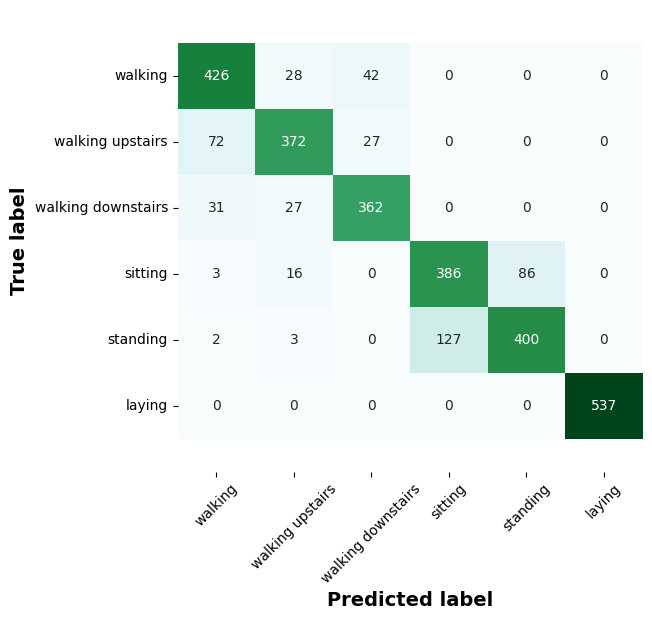

In [60]:
plot_confusion(Y_test, Y_test_pred, activities_description.values())

In [61]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {:.2f}%".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {:.2f}%".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred, target_names=activities_labels))

Accuracy on training set is : 1.00%
Accuracy on test set is : 0.88%
                    precision    recall  f1-score   support

           walking       0.93      0.98      0.95       496
  walking upstairs       0.94      0.95      0.94       471
walking downstairs       0.96      0.88      0.92       420
           sitting       0.79      0.76      0.77       491
          standing       0.78      0.93      0.85       532
            laying       0.95      0.81      0.87       537

          accuracy                           0.88      2947
         macro avg       0.89      0.88      0.89      2947
      weighted avg       0.89      0.88      0.88      2947



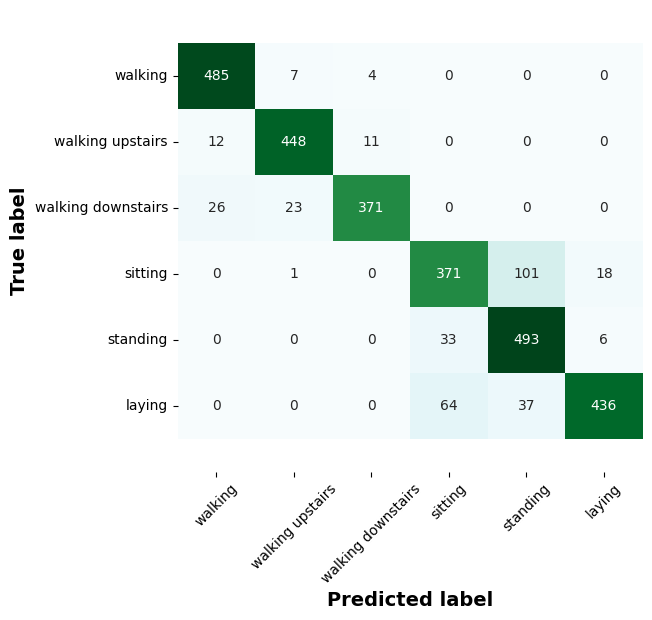

In [62]:
plot_confusion(Y_test, Y_test_pred, activities_description.values())

# Wavelets for Human Activity Recognition (HAR)

In [65]:
import sys
sys.path.append(
    "/content/src"
)

import warnings
warnings.filterwarnings("ignore")

import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter
from tqdm.autonotebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from src.utils import *

In [67]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

activities_labels = [
    'walking',
    'walking upstairs',
    'walking downstairs',
    'sitting',
    'standing',
    'laying'
]

# Правильные пути для Colab
INPUT_FOLDER_TRAIN = '/content/data/raw/UCI HAR Dataset/train/Inertial Signals/'
INPUT_FOLDER_TEST = '/content/data/raw/UCI HAR Dataset/test/Inertial Signals/'

LABELFILE_TRAIN = '/content/data/raw/UCI HAR Dataset/train/y_train.txt'
LABELFILE_TEST = '/content/data/raw/UCI HAR Dataset/test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [68]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

In [69]:
waveletname = 'rbio3.1'
X_train, Y_train = get_uci_har_features(train_signals, train_labels, waveletname)
X_test, Y_test = get_uci_har_features(test_signals, test_labels, waveletname)

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

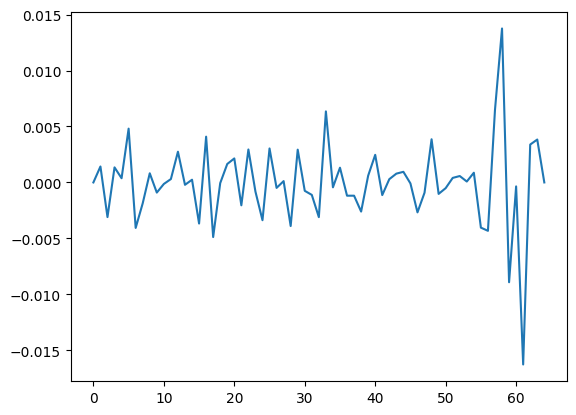

In [70]:
plt.plot(pywt.wavedec(train_signals[0, :, 0], waveletname)[5])

In [71]:
X_train.shape, X_test.shape

((7352, 648), (2947, 648))

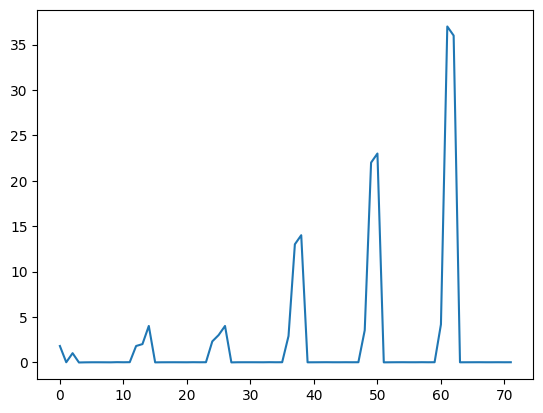

In [74]:
plt.plot(X_train[0][:72]);

<Axes: >

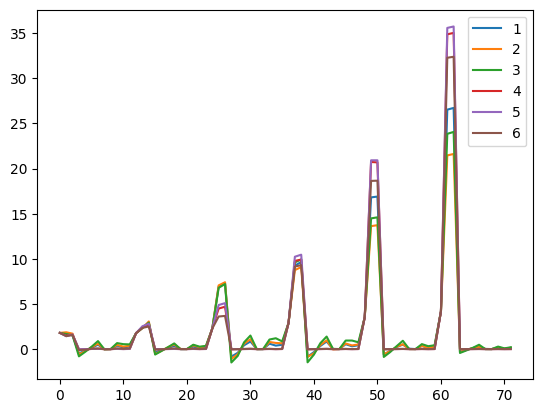

In [75]:
pd.DataFrame(X_train).groupby(pd.Series(Y_train)).mean().iloc[:, :72].T.plot()

In [76]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {:.2f}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {:.2f}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred, target_names=activities_labels))

Accuracy on training set is : 1.00
Accuracy on test set is : 0.92
                    precision    recall  f1-score   support

           walking       0.91      0.95      0.93       496
  walking upstairs       0.90      0.94      0.92       471
walking downstairs       0.92      0.82      0.87       420
           sitting       0.91      0.89      0.90       491
          standing       0.90      0.92      0.91       532
            laying       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



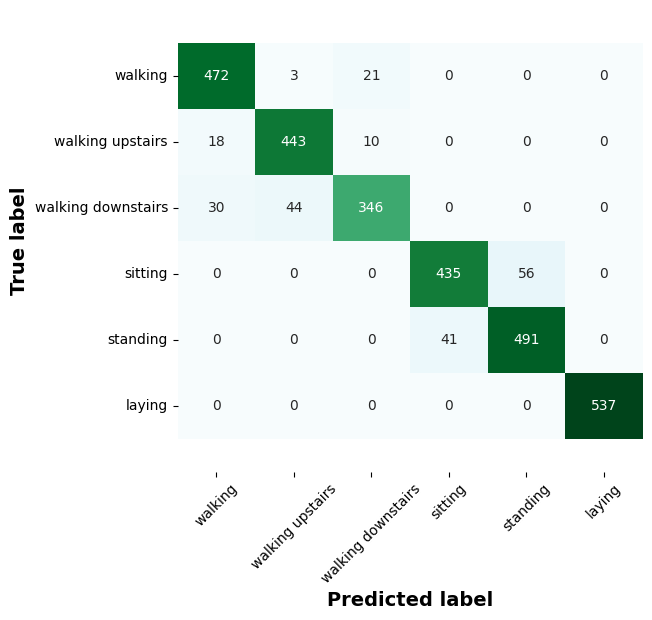

In [77]:
plot_confusion(Y_test, Y_test_pred, activities_description.values())

# Atuomated Feature Generation